In [6]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [7]:
df = pd.read_csv('Gemini_ETHUSD_d.csv',  skiprows=1, parse_dates=True, index_col='Date')
df = df.sort_index().drop(['Symbol','Unix Timestamp'] , axis=1)
df.head()

,Open,High,Low,Close,Volume ETH,Volume USD
Date,,,,,,
2016-05-09,12.00,12.00,9.36,9.98,1317.90,12885.06
2016-05-10,9.98,9.98,9.36,9.68,672.06,6578.20
2016-05-11,9.68,10.47,9.68,10.43,3052.51,30978.11
2016-05-12,10.43,12.00,9.92,10.20,2072.56,22183.39
2016-05-13,10.20,11.59,10.20,10.69,1769.71,18923.55


In [8]:
test_cutoff_date = df.index.max() - timedelta(days=90) # 마지막으로부터 90일치를 test로 쓰고, 나머지는 train

df_test = df[df.index > test_cutoff_date]['Close']
df_train = df[df.index <= test_cutoff_date]['Close']

<AxesSubplot:xlabel='Date'>

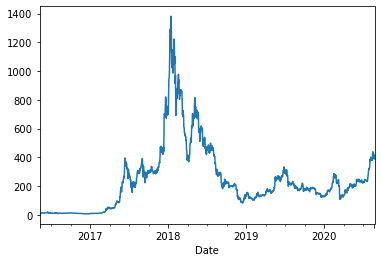

In [9]:
df_train.plot()

In [10]:
df_train

Date
2016-05-09      9.98
2016-05-10      9.68
2016-05-11     10.43
2016-05-12     10.20
2016-05-13     10.69
               ...  
2020-08-18    422.30
2020-08-19    407.55
2020-08-20    414.53
2020-08-21    388.07
2020-08-22    395.98
Name: Close, Length: 1567, dtype: float64

<AxesSubplot:xlabel='Date'>

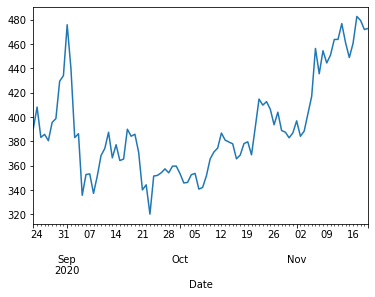

In [11]:
df_test.plot()

Single Step

In [19]:
# CV (교차검증) 데이터를 만드는 과정.

from numpy import array

# Blocking 방법으로 교차검증 데이터를 만드는 과정.
#                  시계열,     train 시퀀스 길이=30, 예측 값의 길이=1.
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
 #    0              100
 #    1              100
    for i in range(len(sequence)): 
        end_ix = i + n_steps_in # train 시퀀스의 끝 index를 계산.
        out_end_ix = end_ix + n_steps_out # 예측 시퀀스의 끝 index 계산.
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x) # 0,30 / 1,31 / 2,32 ...... 69 / 99
        y.append(seq_y) # 31 / 32 / 33 ..........  100
    return array(X), array(y)

raw_seq = df_train # train seq를 block cv가 가능하도록 쪼갠다.
n_steps_in = 30
n_steps_out = 1

X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [20]:
X.shape

(1537, 30, 1)

In [21]:
y.shape

(1537, 1)

In [25]:
# Model을 만들기 시작하는 부분

from keras.models import Sequential, Input
# from keras.layers import LSTM, Dropout, SimpleRNN, GRU
# from keras.layers import Dense

AttributeError: module 'tensorflow.compat.v2.__internal__' has no attribute 'tf2'

In [16]:
model = Sequential()
              # NN의 차원 => 32개의 히든 레이어
# model.add(layer)
              # 차원의 갯수 = 히든레이어 갯수.
model.add(LSTM(128, activation='relu', return_sequences=True, 
                            # n_steps_in=30, n_features = 1
               input_shape=(n_steps_in, n_features)))
model.add(Dropout(0.5))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, activation='relu'))
model.add(Dense(1)) # Dense = 바닐라 NN

# 모델이 학습할 방법을 지정해준다.
#              Gradiant 계산 방법, loss 함수 Mean Absolute Error
#                                loss = mae, mse = Mean Squared Error => 오차가 큰 경우에 패널티가 커짐.
model.compile(optimizer='adam', loss='mse')

NameError: name 'Sequential' is not defined

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               1

In [ ]:
#                  X=입력, y=라벨, epochs=반복수, batch_size = 한번에 병렬학습 시키는 개수
history = model.fit(X, y, epochs=100, batch_size=64)

Epoch 1/100
25/25 [==============================] - 16s 355ms/step - loss: 100306.5625
Epoch 2/100
25/25 [==============================] - 9s 362ms/step - loss: 227575.8438
Epoch 3/100
25/25 [==============================] - 9s 364ms/step - loss: 285525.7188
Epoch 4/100
25/25 [==============================] - 9s 357ms/step - loss: 212184.3594
Epoch 5/100
25/25 [==============================] - 9s 362ms/step - loss: 189014.7188
Epoch 6/100
25/25 [==============================] - 9s 358ms/step - loss: 247340.7969
Epoch 7/100
25/25 [==============================] - 9s 353ms/step - loss: 393189.7812
Epoch 8/100
25/25 [==============================] - 9s 361ms/step - loss: 2002372.2500
Epoch 9/100
25/25 [==============================] - 9s 353ms/step - loss: 9112295.0000
Epoch 10/100
25/25 [==============================] - 9s 354ms/step - loss: 7082502.5000
Epoch 11/100
25/25 [==============================] - 9s 353ms/step - loss: 5176014.0000
Epoch 12/100
25/25 [================

In [ ]:
# train을 그대로 다시 예측.
train_pred = model.predict(X)

In [ ]:
train_pred.shape

(1537, 1)

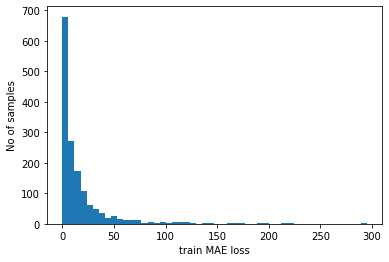

In [ ]:
                                # 전체 데이터에 대해서 예측값 - 실제값
train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss")
plt.ylabel("No of samples")
plt.show()

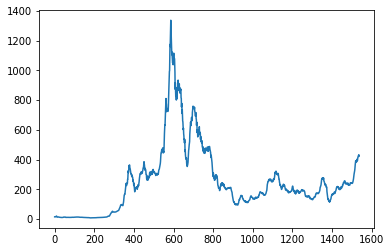

In [ ]:
plt.plot(train_pred)

In [ ]:
train_df_with_pred = df_train.to_frame()[n_steps_in:]
train_df_with_pred['pred'] = train_pred

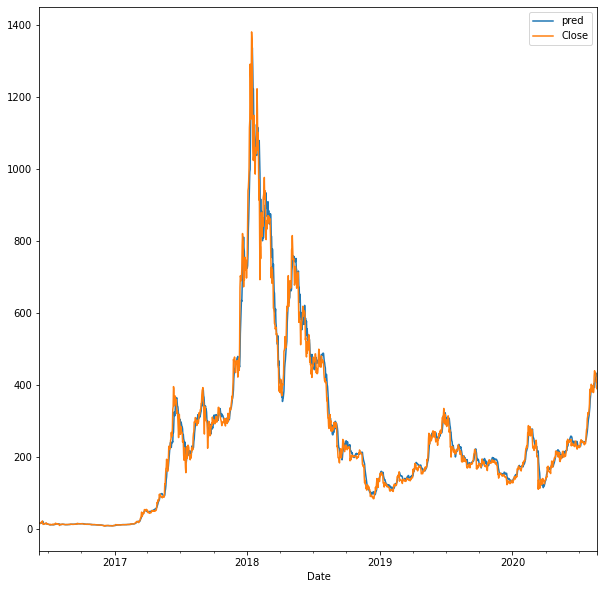

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
train_df_with_pred['pred'].plot(ax=ax, legend=True)
train_df_with_pred['Close'].plot(ax=ax, legend=True)

In [ ]:
test_raw_seq = df_test

test_X, test_y = split_sequence(test_raw_seq, n_steps_in, n_steps_out)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [ ]:
y_pred = model.predict(test_X)

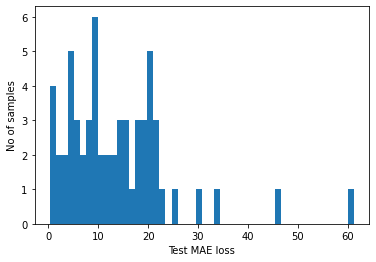

In [ ]:
test_mae_loss = np.mean(np.abs(y_pred - test_y), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
test_df_with_pred = df_test.to_frame()[n_steps_in:]
test_df_with_pred['pred'] = y_pred

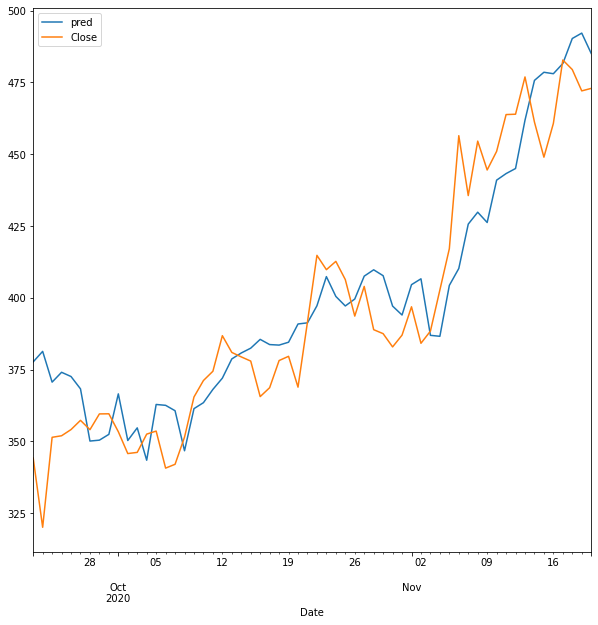

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
test_df_with_pred['pred'].plot(ax=ax, legend=True)
test_df_with_pred['Close'].plot(ax=ax, legend=True)

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

## Multi Step

In [ ]:


raw_seq = df_train

n_steps_in, n_steps_out = 60, 7
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
y

array([[ 11.57,  11.09,  11.13, ...,  10.87,  10.76,  11.52],
       [ 11.09,  11.13,  10.83, ...,  10.76,  11.52,  12.2 ],
       [ 11.13,  10.83,  10.87, ...,  11.52,  12.2 ,  10.2 ],
       ...,
       [438.94, 433.18, 434.  , ..., 422.3 , 407.55, 414.53],
       [433.18, 434.  , 430.74, ..., 407.55, 414.53, 388.07],
       [434.  , 430.74, 422.3 , ..., 414.53, 388.07, 395.98]])

In [ ]:
model = Sequential()
model.add(LSTM(128, activation='relu', 
              #  return_sequences=True, 
               input_shape=(n_steps_in, n_features)))
# model.add(Dropout(0.5))
# model.add(LSTM(1024, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(1024, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(1024, activation='relu'))
# 출력 시계열의 특징이 있다면, 모델링 하는 코드가 들어가야 함.
# 없으면 그냥 쓰면 됨.
model.add(Dense(n_steps_out)) # 7
model.compile(optimizer='adam', loss='mae')

In [ ]:
history = model.fit(X, y, epochs=10, batch_size=64)

Epoch 1/10
24/24 [==============================] - 4s 94ms/step - loss: 227.5251
Epoch 2/10
24/24 [==============================] - 2s 93ms/step - loss: 209.6204
Epoch 3/10
24/24 [==============================] - 2s 92ms/step - loss: 937.7619
Epoch 4/10
24/24 [==============================] - 2s 93ms/step - loss: 1556.0312
Epoch 5/10
24/24 [==============================] - 2s 93ms/step - loss: 852.3376
Epoch 6/10
24/24 [==============================] - 2s 93ms/step - loss: 648.1639
Epoch 7/10
24/24 [==============================] - 2s 94ms/step - loss: 433.4799
Epoch 8/10
24/24 [==============================] - 2s 93ms/step - loss: 351.0766
Epoch 9/10
24/24 [==============================] - 2s 93ms/step - loss: nan
Epoch 10/10
24/24 [==============================] - 2s 90ms/step - loss: nan


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: ignored

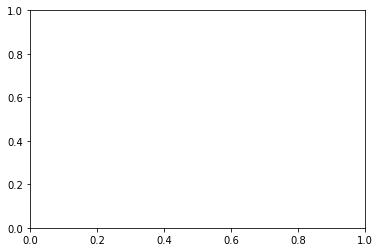

In [ ]:
train_pred = model.predict(X)

train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss")
plt.ylabel("No of samples")
plt.show()

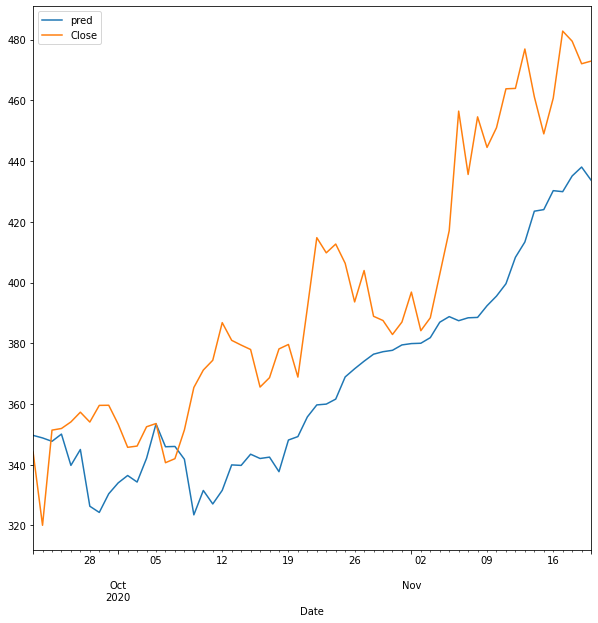

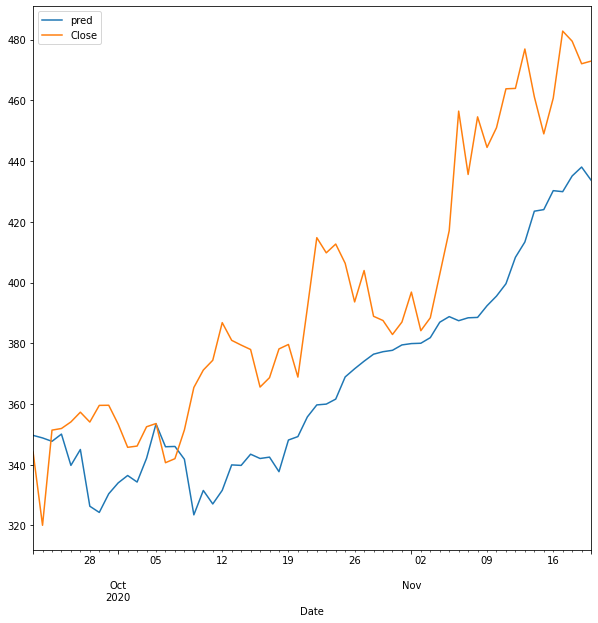

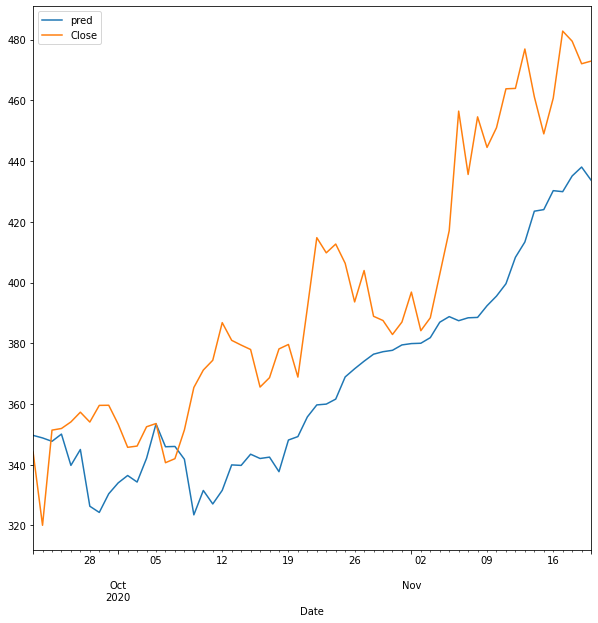

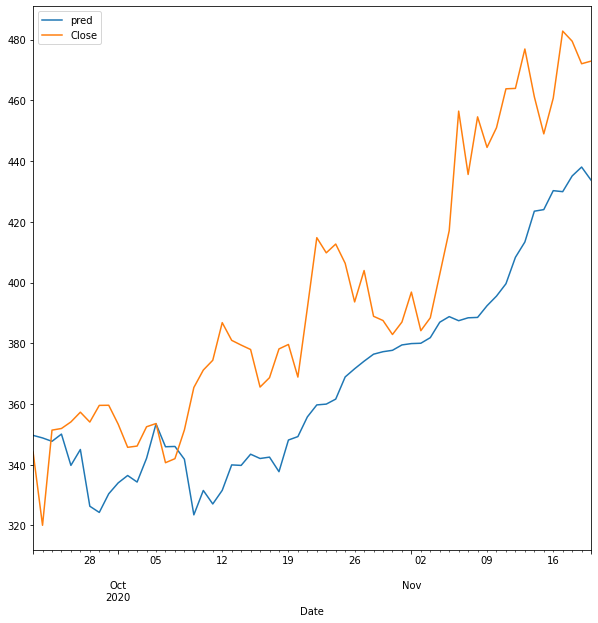

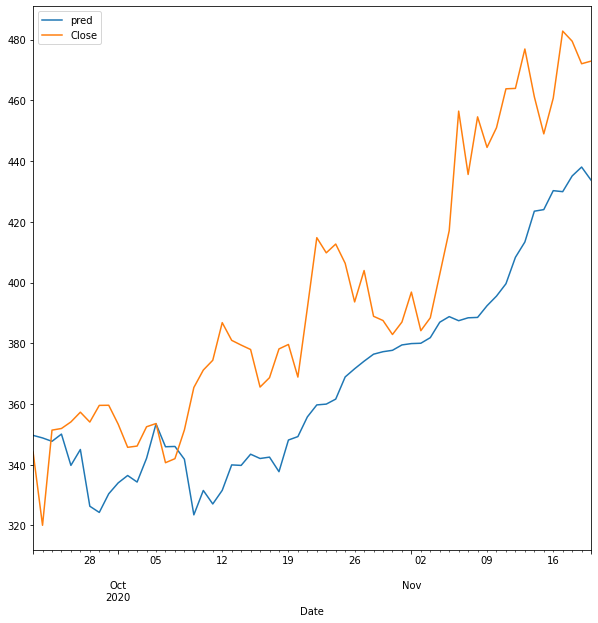

In [ ]:
for i, pred in enumerate(train_pred[:5]):
  train_df_with_pred = df_train[i:i+n_steps_out]
  train_df_with_pred['pred'] = pred
  
  fig, ax = plt.subplots(figsize=(10,10))
  test_df_with_pred['pred'].plot(ax=ax, legend=True)
  test_df_with_pred['Close'].plot(ax=ax, legend=True)
  plt.show()